In [2]:
import logging
import os
import pickle
import time
from functools import partial

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import arch, brax
from datasets import get_dataset
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from pathlib import Path

import jax
import jax.numpy as jnp
from jax import jit, vmap
from jax.example_libraries import optimizers, stax
from jax.tree_util import tree_map
from utils import get_calibration, jaxRNG

/nfs/home/sergioco/anaconda3/envs/jaxsde/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
class CIFAR10C(Dataset):
    def __init__(self, data_dir, transform=None, severity_level=3):
        # Validate severity level
        if severity_level not in range(1, 6):
            raise ValueError("Severity level must be between 1 and 5.")
            
        self.data_files = sorted([f for f in Path(data_dir).glob('*.npy') if 'labels.npy' not in str(f)])
        self.labels = np.load(Path(data_dir) / 'labels.npy')
        self.transform = transform
        self.severity_level = severity_level
        # Each severity level has 10000 images
        self.images_per_level = 10000
        self.start_idx = self.images_per_level * (severity_level - 1)

    def __len__(self):
        # Assuming same number of images per severity level
        return self.images_per_level

    def __getitem__(self, idx):
        # Adjust idx based on severity level
        adjusted_idx = self.start_idx + idx
        # Assuming data_files are in the correct order
        data = np.load(self.data_files[adjusted_idx // self.images_per_level])[adjusted_idx % self.images_per_level]
        label = self.labels[adjusted_idx % self.images_per_level]
        
        # Apply transformations
        if self.transform:
            data = self.transform(data)

        return data, label

In [182]:
# Define all the args
model= 'psdebnn' #'psdebnn'
print("Using model:", model)
output='output-psde-sdefirst-07'
seed=42
stl=False
lr=0.0007
epochs=100
bs=128
test_bs=1000
nsamples=1
w_init=-1.0
b_init=-1.0
p_init=-1.0
pause_every=200
no_drift=False
ou_dw=True
diff_coef=0.1
ood=False
ds='cifar10'
severity_level = 5 # CHANGE ACCORDINGLY
no_xt=True
acc_grad=1
aug=0
remat=False
ema=0.999
meanfield_sdebnn=False
infer_w0=False
w0_prior_std=0.1
disable_test=False
verbose=True
nblocks='2-2-2'
block_type=0
fx_dim=64
fx_actfn='softplus'
fw_dims='2-128-2'
fw_actfn='softplus'
lr_sched='constant'
rng_generator = jaxRNG(seed=seed)

# PSDEBNN specific
ode_first=False
timecut=0.7
if model == 'psdebnn': kl_coef=(1/(timecut))*10**-4
else: kl_coef=1e-3
fix_w1=False
method_ode='euler'

if ds == 'cifar10':
    print("Using CIFAR-10 dataset")
    train_loader, train_eval_loader, val_loader, test_loader, input_size, train_size = get_dataset(bs, test_bs, "cifar10")

    #indices = torch.randperm(len(test_loader.dataset)).tolist() # Check
    #test_subset_indices = indices[:test_bs]
    #test_subset = torch.utils.data.Subset(test_loader.dataset, test_subset_indices) # Check
    #test_loader = DataLoader(test_subset, batch_size=test_bs, shuffle=False)
    num_batches = len(test_loader)
    print(f"Number of test batches: {num_batches}")

elif ds == 'cifar10c':
    print("Using CIFAR-10-C dataset at severity level", severity_level)
    # Need to download manually from https://zenodo.org/records/2535967/files/CIFAR-10-C.tar?download=1
    data_dir = "data/cifar10c"

    # Define your transform
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
    ])

    cifar10c_dataset = CIFAR10C(data_dir=data_dir, transform=transform, severity_level=1)

    # Create test DataLoader for the CIFAR-10-C dataset
    #test_loader = DataLoader(cifar10c_dataset, batch_size=test_bs, shuffle=True)
    #num_batches = len(test_loader)
    #print(f"Number of test batches: {num_batches}")

    # Since DataLoader will iterate over the dataset, we can just grab the first 1000 images
    # during the actual testing loop. If we want to explicitly create a smaller dataset:

    indices = torch.randperm(len(cifar10c_dataset)).tolist()
    # Get the first 1000 indices after shuffling
    test_subset_indices = indices[:test_bs]
    test_subset = torch.utils.data.Subset(cifar10c_dataset, test_subset_indices)
    test_loader = DataLoader(test_subset, batch_size=test_bs, shuffle=False)
    num_batches = len(test_loader)
    print(f"Number of test batches: {num_batches}")

elif ds == 'svhn':
    print("Using SVHN dataset")
    train_loader, train_eval_loader, val_loader, test_loader, input_size, train_size = get_dataset(bs, test_bs, "svhn")

    indices = torch.randperm(len(test_loader.dataset)).tolist()
    test_subset_indices = indices[:test_bs]
    test_subset = torch.utils.data.Subset(test_loader.dataset, test_subset_indices)
    test_loader = DataLoader(test_subset, batch_size=int(test_bs/10), shuffle=False)
    num_batches = len(test_loader)
    print(f"Number of test batches: {num_batches}")
    
else:
    raise ValueError("Dataset not supported!")
    
# SDEBNN specific
mf = partial(brax.MeanField, disable=True) if kl_coef == 0. else brax.MeanField
fw_dims = list(map(int, fw_dims.split("-")))
layers = [mf(arch.Augment( aug))]
nblocks = list(map(int, nblocks.split("-")))
opt_init, opt_update, get_params = optimizers.adam(7e-4)

# Load the checkpoint if it exists
checkpoint_path = os.path.join(output, 'best_model_checkpoint.pkl')
if os.path.exists(checkpoint_path):
    logging.warning("Loading checkpoints...")
    with open(checkpoint_path, "rb") as f:
        checkpoint = pickle.load(f)

    # Extract states from the checkpoint
    start_epoch = checkpoint['epoch']
    best_val_acc = checkpoint['best_val_acc']
    global_step = checkpoint['global_step']
    opt_state = checkpoint['optimizer_state']
    ema_params = checkpoint['ema_state']
    params = checkpoint['model_state']  # Loaded parameters
    print(f"Successfully loaded checkpoints for epoch {start_epoch} with best validation accuracy {best_val_acc}")
else:
    raise SystemExit("No checkpoint found!")

Using model: psdebnn
Using CIFAR-10 dataset
Files already downloaded and verified
Files already downloaded and verified


Number of test batches: 10
Successfully loaded checkpoints for epoch 98 with best validation accuracy 0.8188000321388245


In [183]:
#inference_times = []
#nlls = []
#eces = []
#nfes = []

In [184]:
def _nll(params, batch, rng):
    inputs, targets = batch
    preds, kl, info_dict = _predict(params, inputs, rng=rng, full_output=False)
    nll = -jnp.mean(jnp.sum(preds * targets, axis=1))
    return preds, nll, kl, info_dict


@partial(jit, static_argnums=(3,))
def sep_loss(params, batch, rng, kl_coef):  # no backprop
    preds, nll, kl, _ = _nll(params, batch, rng)
    if kl_coef > 0:
        obj_loss = nll + kl * kl_coef
    else:
        obj_loss = nll
    _sep_loss = {'loss': obj_loss, 'kl': kl, 'nll': nll, 'preds': preds}
    return obj_loss, _sep_loss

@partial(jit, static_argnums=(3,))
def loss(params, batch, rng, kl_coef):  # backprop so checkpoint
    _, nll, kl, _ = jax.checkpoint(_nll)(params, batch, rng)
    if kl_coef > 0:
        return nll + kl * kl_coef
    else:
        return nll

@jit
def predict(params, inputs, rng): 
    return _predict(params, inputs, rng=rng, full_output=True)

@partial(jit, static_argnums=(2,))
def accuracy(params, data, nsamples, rng):
    inputs, targets = data
    target_class = jnp.argmax(targets, axis=1)
    rngs = jax.random.split(rng, nsamples)
    preds, _, info_dic = vmap(predict, in_axes=(None, None, 0))(params, inputs, rngs)
    preds = jnp.stack(preds, axis=0)
    avg_preds = preds.mean(0)
    predicted_class = jnp.argmax(avg_preds, axis=1)
    n_correct = jnp.sum(predicted_class == target_class)
    n_total = inputs.shape[0]
    wts = info_dic[model+'_w'] 
    wts = jnp.stack(wts, axis=0)
    avg_wts = wts.mean(0)
    return n_correct, n_total, avg_preds, avg_wts

def update_ema(ema_params, params, momentum=0.999):
    return tree_map(lambda e, p: e * momentum + p * (1 - momentum), ema_params, params)

def evaluate(params, data_loader, input_size, nsamples, rng_generator, kl_coef):
    n_total = 0
    n_correct = 0
    nll = 0
    kl = 0
    logits = np.array([])
    wts = np.array([])
    labels = np.array([])
    for inputs, targets in data_loader:
        targets = jax.nn.one_hot(jnp.array(targets), num_classes=10)
        inputs = jnp.array(inputs).reshape((-1,) + (input_size[-1],) + input_size[:2])
        inputs = jnp.transpose(inputs, (0, 2, 3, 1))  # Permute from NCHW to NHWC
        batch_correct, batch_total, _logits, _wts = accuracy(
            params, (inputs, targets), nsamples, rng_generator.next()
        )
        n_correct = n_correct + batch_correct
        _, batch_nll, batch_kl, _ = jit(_nll)(params, (inputs, targets), rng_generator.next())
        if n_total == 0:
            logits = np.array(_logits)
            wts = np.array(_wts)
            labels = np.array(targets)
        else:
            logits = np.concatenate([logits, np.array(_logits)], axis=0)
            wts = np.concatenate([wts, np.array(_wts)], axis=0)
            labels = np.concatenate([labels, targets], axis=0)
        n_total = n_total + batch_total
        nll = nll + batch_nll
        kl = kl + batch_kl
    return n_correct / n_total, jnp.stack(logits, axis=0), labels, nll / n_total, kl / n_total, jnp.stack(wts, axis=0)

nsteps = 30 # CHANGE FOR EACH EXPERIMENT

if ood:
    print("Starting OOD experiment with dataset:", ds)
else:
    print("Starting ID experiment")

if model == "sdebnn":
    for i, nb in enumerate(nblocks):
        fw = arch.MLP(fw_dims, actfn=fw_actfn, xt=no_xt, ou_dw=ou_dw, nonzero_w=w_init, nonzero_b=b_init, p_scale=p_init)  # weight network is time dependent
        if meanfield_sdebnn:
            layers.extend([mf(brax.SDEBNN(block_type,
                                            fx_dim,
                                            fx_actfn,
                                            fw,
                                            diff_coef=diff_coef,
                                            stl=stl,
                                            xt=no_xt,
                                            nsteps=nsteps,
                                            remat=remat,
                                            w_drift=not no_drift,
                                            stax_api=True,
                                            infer_initial_state=infer_w0,
                                            initial_state_prior_std=w0_prior_std)) for _ in range(nb)
            ])
        else:
            layers.extend([brax.SDEBNN( block_type,
                                        fx_dim,
                                        fx_actfn,
                                        fw,
                                        diff_coef=diff_coef,
                                        stl=stl,
                                        xt=no_xt,
                                        nsteps=nsteps,
                                        remat=remat,
                                        w_drift=not no_drift,
                                        infer_initial_state=infer_w0,
                                        initial_state_prior_std=w0_prior_std) for _ in range(nb)
            ])
        if i < len(nblocks) - 1:
            layers.append(mf(arch.SqueezeDownsample(2)))
    layers.append(mf(stax.serial(stax.Flatten, stax.Dense(10), stax.LogSoftmax)))

    init_random_params, _predict = brax.bnn_serial(*layers)

elif model == "psdebnn":
    for i, nb in enumerate(nblocks):
        fw = arch.MLP(fw_dims, actfn=fw_actfn, xt=no_xt, ou_dw=ou_dw, nonzero_w=w_init, nonzero_b=b_init, p_scale=p_init)  # weight network is time dependent
        if meanfield_sdebnn:
            layers.extend([mf(brax.PSDEBNN( block_type,
                                            fx_dim,
                                            fx_actfn,
                                            fw,
                                            diff_coef=diff_coef,
                                            stl=stl,
                                            xt=no_xt,
                                            nsteps=nsteps,
                                            remat=remat,
                                            w_drift=not no_drift,
                                            stax_api=True,
                                            infer_initial_state=infer_w0,
                                            initial_state_prior_std=w0_prior_std,
                                            ode_first=ode_first,
                                            timecut=timecut,
                                            method_ode=method_ode,
                                            fix_w1=fix_w1)) for _ in range(nb)
            ])
        else:
            layers.extend([brax.PSDEBNN(block_type,
                                        fx_dim,
                                        fx_actfn,
                                        fw,
                                        diff_coef=diff_coef,
                                        stl=stl,
                                        xt=no_xt,
                                        nsteps=nsteps,
                                        remat=remat,
                                        w_drift=not no_drift,
                                        infer_initial_state=infer_w0,
                                        initial_state_prior_std=w0_prior_std,
                                        ode_first=ode_first,
                                        timecut=timecut,
                                        method_ode=method_ode,
                                        fix_w1=fix_w1) for _ in range(nb)
            ])
        if i < len(nblocks) - 1:
            layers.append(mf(arch.SqueezeDownsample(2)))
    layers.append(mf(stax.serial(stax.Flatten, stax.Dense(10), stax.LogSoftmax)))

    init_random_params, _predict = brax.bnn_serial(*layers)

# for inputs, targets in tqdm(test_loader): # evaluate already deals with the loop
start_time = time.time()
acc, logits, targets, nll, _, _ = evaluate(params, test_loader, input_size, nsamples, rng_generator, kl_coef=kl_coef)

# Calculate inference time
inference_time = time.time() - start_time

# Convert logits to probabilities
if ood:
    probabilities_ood = jax.nn.softmax(logits)
    # TODO: might be better to use utils.ECE or utils.compute_acc_bin
    cal = get_calibration(targets, probabilities_ood)
else:
    probabilities_id = jax.nn.softmax(logits) # probabilities_ood when ood data is used
    # TODO: might be better to use utils.ECE or utils.compute_acc_bin
    cal = get_calibration(targets, probabilities_id)

print(f"Inference time with {nsteps} steps: {inference_time} (s)")
print(f"Accuracy with {nsteps} steps: {acc}")
print(f"NLL with {nsteps} steps: {nll}")
print(f"ECE with {nsteps} steps: {cal['ece']}")

#inference_times.append(inference_time)
#nlls.append(nll)
#eces.append(cal['ece'])
#nfes.append(nsteps)
#nsteps += 1
print("Experiment run sucessfully!")

Starting ID experiment
there were [   0.    0.   34.  195.  434.  624.  639.  679.  899. 6268.] items in bins 1-10
Inference time with 30 steps: 42.7576789855957 (s)
Accuracy with 30 steps: 0.8133000135421753
NLL with 30 steps: 0.0005994966486468911
ECE with 30 steps: 0.05907101381058306
Experiment run sucessfully!


In [35]:
#nsteps = 6

10000

SDEFirst (t=0.1):
Starting ID experiment
there were [   0.    0.   14.   89.  172.  307.  308.  293.  449. 3174.] items in bins 1-10
Inference time with 30 steps: 19.003776788711548 (s)
Accuracy with 30 steps: 0.8278000354766846
NLL with 30 steps: 0.00010390066745458171
ECE with 30 steps: 0.056724256641678336
Experiment run sucessfully!

Starting OOD experiment with dataset: svhn
there were [   0.    0.   65.  510. 1049. 1058.  829.  630.  446.  413.] items in bins 1-10
Inference time with 30 steps: 18.626373052597046 (s)
Accuracy with 30 steps: 0.1064000055193901
NLL with 30 steps: 0.0013806936331093311
ECE with 30 steps: 0.5005235960628545
Experiment run sucessfully!

ODEFirst (t=0.1):
Starting ID experiment
there were [0.000e+00 0.000e+00 3.000e+00 4.500e+01 1.110e+02 2.220e+02 1.740e+02
 2.410e+02 3.370e+02 3.358e+03] items in bins 1-10
Inference time with 30 steps: 20.411700010299683 (s)
Accuracy with 30 steps: 0.853600025177002
NLL with 30 steps: 0.00010676541569409892
ECE with 30 steps: 0.07510993250256065
Experiment run sucessfully!

Starting OOD experiment with dataset: svhn
there were [  0.   0.  12. 217. 625. 840. 832. 807. 759. 908.] items in bins 1-10
Inference time with 30 steps: 20.57161784172058 (s)
Accuracy with 30 steps: 0.0966000035405159
NLL with 30 steps: 0.0015536367427557707
ECE with 30 steps: 0.6004052897645822
Experiment run sucessfully!

SDEBNN:
Starting ID experiment
there were [0.000e+00 0.000e+00 1.000e+00 1.500e+01 6.600e+01 1.720e+02 1.780e+02
 1.930e+02 2.670e+02 3.107e+03] items in bins 1-10
Inference time with 30 steps: 25.098942041397095 (s)
Accuracy with 30 steps: 0.8452000617980957
NLL with 30 steps: 0.00014759805344510823
ECE with 30 steps: 0.1170470892726817
Experiment run sucessfully!

Starting OOD experiment with dataset: svhn
there were [   0.    0.    6.  125.  364.  573.  625.  678.  747. 1881.] items in bins 1-10
Inference time with 30 steps: 23.863789796829224 (s)
Accuracy with 30 steps: 0.11340000480413437
NLL with 30 steps: 0.002506544580683112
ECE with 30 steps: 0.6671432346124101
Experiment run sucessfully!

### OOD Detection

Scores shape: (11000,)
Scores shape after removing NaN values: (11000,)


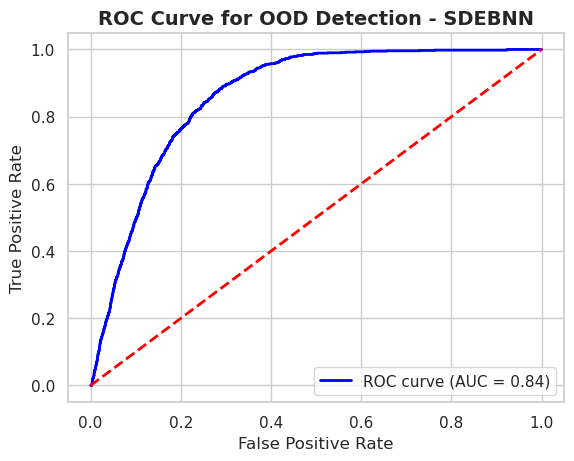

In [65]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import numpy as np
import torch

# Using entropy as confidence scores
def entropy(probs):
    return -torch.sum(probs * torch.log(probs), dim=1)

# Create PyTorch tensors directly from NumPy arrays
probabilities_id_np = np.array(probabilities_id)
probabilities_id_torch = torch.tensor(probabilities_id_np)

probabilities_ood_np = np.array(probabilities_ood)
probabilities_ood_torch = torch.tensor(probabilities_ood_np)

id_probs_entropy = entropy(probabilities_id_torch)
ood_probs_entropy = entropy(probabilities_ood_torch)

# Combine ID and OOD entropy scores
scores = torch.cat([id_probs_entropy, ood_probs_entropy]).numpy()
labels = np.concatenate([np.zeros(len(id_probs_entropy)), np.ones(len(ood_probs_entropy))])

print(f"Scores shape: {scores.shape}")

# Find the indices of NaN values in the scores array
nan_indices = np.isnan(scores)

# Remove NaN values from both scores and labels arrays
scores = scores[~nan_indices]
labels = labels[~nan_indices]

print(f"Scores shape after removing NaN values: {scores.shape}")

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(labels, scores)
auc = roc_auc_score(labels, scores)

# Plotting the ROC curve
plt.figure()
 plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve for OOD Detection - SDEBNN', fontweight='bold', fontsize=14)
plt.legend(loc="lower right")
plt.savefig('experiments/roc_curves/rc_SDEBNN.pdf', dpi=300, bbox_inches='tight')
plt.show()

### Predictive Entropy Analysis

Number of high uncertainty predictions: 352
Number of low uncertainty predictions: 648
Mean entropy: 0.8677147030830383 and std entropy: 0.3245680332183838


/nfs/home/sergioco/anaconda3/envs/jaxsde/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


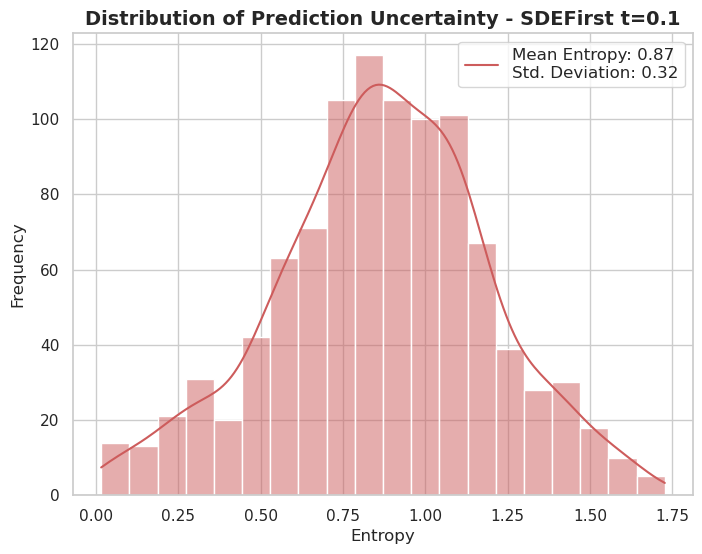

In [175]:
"""
- Compare with Ground Truth: If possible, compare entropy values with the ground truth to see if higher entropy correlates with incorrect predictions.
- Correlation Analysis: Look for correlations between entropy and other factors, e.g. difficulty of examples, to understand in what situations the models are more uncertain.

WHAT WE EXPECT:
1. Well-calibrated Model: A model with good uncertainty calibration will have a wide range of entropy values, with higher entropy corresponding to less certain predictions.
2. Overconfident Model: If a model is overconfident, you'll see a distribution skewed towards lower entropy values, even for incorrect predictions.
3. Underconfident Model: Conversely, an underconfident model will have a distribution skewed towards higher entropy values, indicating uncertainty even in correct predictions.
4. Partially vs. Fully Stochastic: The partially stochastic model might show a tighter distribution if it's better at distinguishing clear cases, while the fully stochastic model might exhibit higher entropy overall, reflecting greater inherent uncertainty.

The key is to see if higher entropy aligns with instances where the model should be uncertain (e.g., incorrect predictions, OOD data) and lower entropy aligns with correct and confident predictions.
"""
if ood:
    probabilities_np = np.array(probabilities_ood)
else:
    probabilities_np = np.array(probabilities_id)
probabilities_torch = torch.tensor(probabilities_np)

entropy = -torch.sum(probabilities_torch * torch.log(probabilities_torch), dim=1)

# Find the indices of NaN values in the scores array
nan_indices = np.isnan(entropy.numpy())
# Remove NaN values from both scores and labels arrays
entropy = entropy[~nan_indices]

mean_entropy = torch.mean(entropy) # Should be high for OOD data
std_entropy = torch.std(entropy)

uncertainty_threshold = 1.
# Classify predictions
high_uncertainty_predictions = entropy.numpy() > uncertainty_threshold
low_uncertainty_predictions = entropy.numpy() <= uncertainty_threshold
print(f"Number of high uncertainty predictions: {np.sum(high_uncertainty_predictions)}")
print(f"Number of low uncertainty predictions: {np.sum(low_uncertainty_predictions)}")

print(f"Mean entropy: {mean_entropy} and std entropy: {std_entropy}")
# Set Seaborn style
sns.set(style="whitegrid")

# Create a histogram plot
plt.figure(figsize=(8, 6))
sns.histplot(entropy.numpy(), bins=20, kde=True, color='indianred') # indianred, royalblue, springgreen

# Add labels and title
plt.xlabel('Entropy', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Prediction Uncertainty - SDEFirst t=0.1', fontsize=14, fontweight='bold')
plt.legend([f'Mean Entropy: {mean_entropy:.2f}\nStd. Deviation: {std_entropy:.2f}'], fontsize=12, loc='upper right')
#plt.savefig('experiments/entropy_analysis/entropy_sdefirst_01_OOD.pdf', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

In [15]:
ood=True

SDEFirst (t=0.1):
ID Experiment:
Number of high uncertainty predictions: 549
Number of low uncertainty predictions: 4451
Mean entropy: 0.32678788900375366 and std entropy: 0.4287969470024109

OOD Experiment:
Number of high uncertainty predictions: 2710
Number of low uncertainty predictions: 2290
Mean entropy: 1.0001659393310547 and std entropy: 0.37521806359291077

ODEFirst (t=0.1):
ID Experiment:
Number of high uncertainty predictions: 276
Number of low uncertainty predictions: 4724
Mean entropy: 0.21221035718917847 and std entropy: 0.34835919737815857

OOD Experiment:
Number of high uncertainty predictions: 1339
Number of low uncertainty predictions: 3661
Mean entropy: 0.7546650767326355 and std entropy: 0.364822119474411

SDEBNN:
ID Experiment:
Number of high uncertainty predictions: 133
Number of low uncertainty predictions: 4861
Mean entropy: 0.1565878689289093 and std entropy: 0.28682979941368103

OOD Experiment:
Number of high uncertainty predictions: 707
Number of low uncertainty predictions: 4293
Mean entropy: 0.5507951378822327 and std entropy: 0.37698736786842346

## Old

SDEBNN:
ID Experiment:
Number of high uncertainty predictions: 3
Number of low uncertainty predictions: 97
Mean entropy: 0.5965458154678345 and std entropy: 0.5066224336624146

OOD Experiment:
Number of high uncertainty predictions: 502
Number of low uncertainty predictions: 498
Mean entropy: 0.9898431301116943 and std entropy: 0.32811787724494934

PSDEBNN ODEFirst:
ID Experiment:
Number of high uncertainty predictions: 62
Number of low uncertainty predictions: 938
Mean entropy: 0.21181705594062805 and std entropy: 0.35595035552978516

OOD Experiment:
Number of high uncertainty predictions: 298
Number of low uncertainty predictions: 702
Mean entropy: 0.7827900648117065 and std entropy: 0.3742108643054962

PSDEBNN ODEFirst (0.5):
ID Experiment:
Number of high uncertainty predictions: 66
Number of low uncertainty predictions: 934
Mean entropy: 0.2550690472126007 and std entropy: 0.37884974479675293

OOD Experiment:
Number of high uncertainty predictions: 236
Number of low uncertainty predictions: 764
Mean entropy: 0.7369115948677063 and std entropy: 0.3504610061645508

PSDEBNN SDEFirst (fiw_w1):
ID Experiment:
Number of high uncertainty predictions: 35
Number of low uncertainty predictions: 965
Mean entropy: 0.18086004257202148 and std entropy: 0.3192775845527649

OOD Experiment: (WEIRD DISTRIBUTION)
Number of high uncertainty predictions: 145
Number of low uncertainty predictions: 855
Mean entropy: 0.5438295602798462 and std entropy: 0.3869096338748932

ODENet: WARNING!!! - How do these results make sense???
ID Experiment:
Number of high uncertainty predictions: 65
Number of low uncertainty predictions: 935
Mean entropy: 0.22723330557346344 and std entropy: 0.3764367997646332

OOD Experiment:
Number of high uncertainty predictions: 382
Number of low uncertainty predictions: 618
Mean entropy: 0.845481276512146 and std entropy: 0.42366594076156616

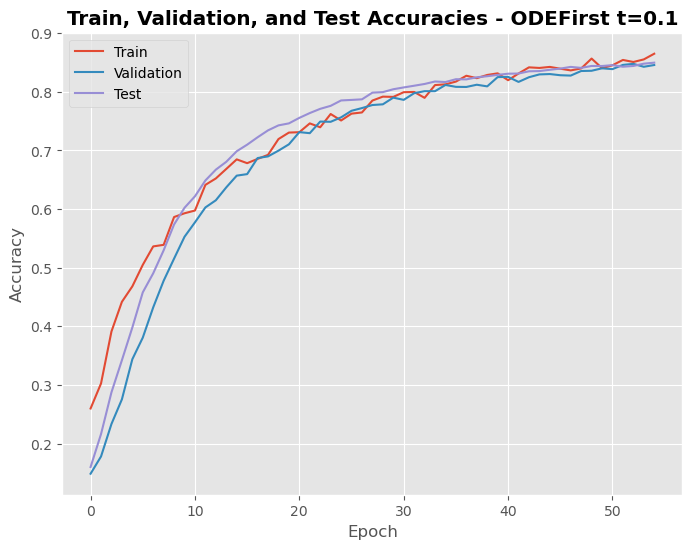

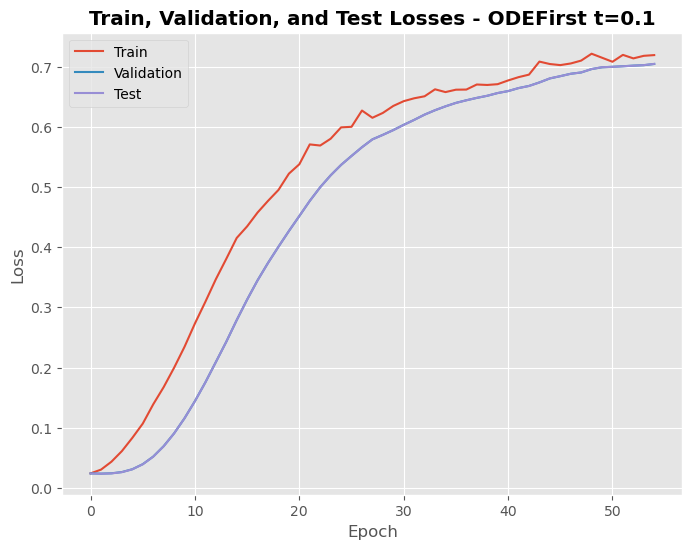

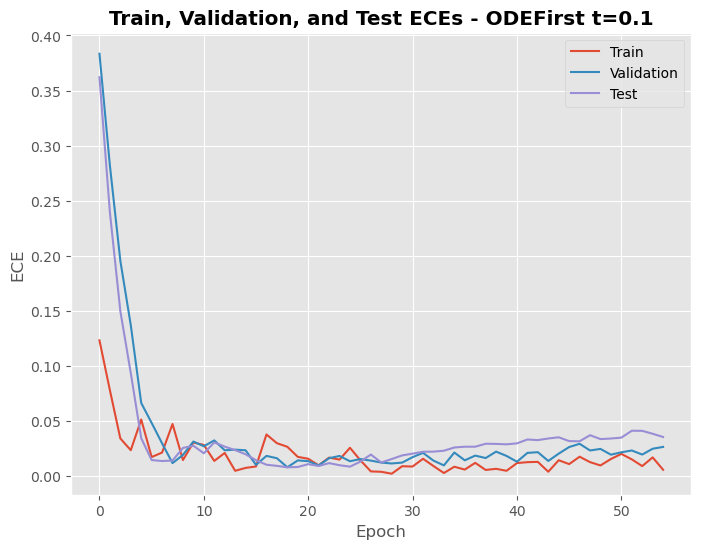

381.4599999999999

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt

file_path = 'output-psde-horizontal-05/results.txt'

# Open the file and read its contents
with open(file_path, 'r') as file:
    contents = file.readlines()

# Output the first few lines to get a sense of the data structure
contents[:10]  # Display the first 10 lines for brevity

# Parse the contents and extract data
epoch_times = []
train_accuracies = []
val_accuracies = []
test_accuracies = []
train_losses = []
val_losses = []
test_losses = []
train_ECEs = []
val_ECEs = []
test_ECEs = []

# Regular expression pattern for extracting data
pattern = r'Epoch (\d+) in ([\d.]+) sec \| Train acc ([\d.]+) \| Val acc ([\d.]+) \| Test acc ([\d.]+) \| Train loss ([\d.e+-]+) \| Val loss ([\d.e+-]+) \| Test loss ([\d.e+-]+) \| Train KL [\d.e+-]+ \| Val KL [\d.e+-]+ \| Test KL [\d.e+-]+ \| Train ECE ([\d.e+-]+) \| Val ECE ([\d.e+-]+) \| Test ECE ([\d.e+-]+)'

# Extract data using regex
for line in contents:
    match = re.search(pattern, line)
    if match:
        epoch_times.append(float(match.group(2)))
        train_accuracies.append(float(match.group(3)))
        val_accuracies.append(float(match.group(4)))
        test_accuracies.append(float(match.group(5)))
        train_losses.append(float(match.group(6)))
        val_losses.append(float(match.group(7)))
        test_losses.append(float(match.group(8)))
        train_ECEs.append(float(match.group(9)))
        val_ECEs.append(float(match.group(10)))
        test_ECEs.append(float(match.group(11)))

# Compute average time per epoch
average_time_per_epoch = np.mean(epoch_times)

# Now let's create the visualizations
# Set the style for the plots
plt.style.use('ggplot')

# Function to create a plot
def create_plot(y_values, y_label, title, file_name):
    plt.figure(figsize=(8, 6))
    plt.plot(y_values[0], label='Train')
    plt.plot(y_values[1], label='Validation')
    plt.plot(y_values[2], label='Test')
    plt.xlabel('Epoch')
    plt.ylabel(y_label)
    plt.title(title, fontweight='bold')
    plt.legend()
    plt.savefig(f'experiments/train_curves/{file_name}.pdf', dpi=300, bbox_inches='tight')
    plt.show()

# 2. The progress of the train, validation, and test accuracies
create_plot([train_accuracies[:100], val_accuracies[:100], test_accuracies[:100]], 'Accuracy', 'Train, Validation, and Test Accuracies - ODEFirst t=0.1', file_name='acc_odefirst_01')

# 3. The progress of the train, validation, and test losses
create_plot([train_losses, val_losses, test_losses], 'Loss', 'Train, Validation, and Test Losses - ODEFirst t=0.1', file_name='loss_odefirst_01')

# 4. The progress of the train, validation, and test ECEs
create_plot([train_ECEs, val_ECEs, test_ECEs], 'ECE', 'Train, Validation, and Test ECEs - ODEFirst t=0.1', file_name='ece_odefirst_01')

average_time_per_epoch

### LL Laplacian Approx (ResNet)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import torch.distributions as dists
from laplace import Laplace
import numpy as np

# Set seeds for reproducibility
torch.manual_seed(7777)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

# Load CIFAR-10 datasets
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the pretrained model and move it to the device (CUDA if available)
model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)
model = model.to(device)
model.eval()

# Fit the Laplace approximation
la = Laplace(model, 'classification', subset_of_weights='last_layer', hessian_structure='kron')
la.fit(trainloader)
la.optimize_prior_precision(method='marglik')

@torch.no_grad()
def predict(dataloader, model, laplace=False):
    py = []

    for x, _ in dataloader:
        x = x.to(device)  # Move input data to the same device as the model
        if laplace:
            py.append(model(x))
        else:
            py.append(torch.softmax(model(x), dim=-1))

    return torch.cat(py).cpu()

# Predictions using the model with and without Laplace approximation
probs_map = predict(testloader, model, laplace=False)
probs_laplace = predict(testloader, la, laplace=True)

# Calculate accuracy, ECE, and NLL for MAP and Laplace
targets = torch.cat([y for _, y in testloader], dim=0).numpy()
# Convert targets to a torch tensor if it's not already
targets = torch.tensor(targets)

# Calculate accuracy for MAP
predictions_map = probs_map.argmax(-1)
correct_map = predictions_map.eq(targets).sum().item()
acc_map = correct_map / targets.size(0)

# Calculate accuracy for Laplace
predictions_laplace = probs_laplace.argmax(-1)
correct_laplace = predictions_laplace.eq(targets).sum().item()
acc_laplace = correct_laplace / targets.size(0)

print(f'[MAP] Accuracy: {acc_map:.2f}')
print(f'[Laplace] Accuracy: {acc_laplace:.2f}')

In [ ]:
from netcal.metrics import ECE

# ECE computation
ece_metric = ECE(bins=50)

# Convert the probabilities and targets to numpy for ECE calculation
probs_map_np = probs_map.numpy()
probs_laplace_np = probs_laplace.numpy()
targets_np = targets.numpy()

# ECE for MAP
ece_map = ece_metric.measure(probs_map_np, targets_np)

# ECE for Laplace
ece_laplace = ece_metric.measure(probs_laplace_np, targets_np)

print(f'[MAP] Accuracy: {acc_map:.6f}, ECE: {ece_map:.6f}')
print(f'[Laplace] Accuracy: {acc_laplace:.6f}, ECE: {ece_laplace:.6f}')